## Prepare Dataset

In [18]:
import h5py
import numpy as np

In [2]:
train_dataset = h5py.File("train/digitStruct.mat", "r")
test_dataset = h5py.File("test/digitStruct.mat", "r")

In [3]:
train_dataset.keys()

KeysView(<HDF5 file "digitStruct.mat" (mode r)>)

In [4]:
# there are 33402 training examples
for key in train_dataset["digitStruct"].keys():
    print(key)
    print(train_dataset["digitStruct"][key])  

bbox
<HDF5 dataset "bbox": shape (33402, 1), type "|O">
name
<HDF5 dataset "name": shape (33402, 1), type "|O">


In [5]:
def getName(dataset, index):
    names = dataset["digitStruct"]["name"]
    return ''.join([chr(c[0]) for c in dataset[names[index][0]].value])

In [6]:
getName(train_dataset, 33401)

'33402.png'

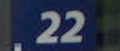

In [39]:
from PIL import Image

Image.open("train/" + getName(train_dataset, 33400))

In [8]:
def bboxHelper(dataset, attr):
    if (len(attr) > 1):
        attr = [dataset[attr.value[j].item()].value[0][0] for j in range(len(attr))]
    else:
        attr = [attr.value[0][0]]
        
    return attr

def getBbox(dataset, index):
    item = dataset[dataset["digitStruct"]["bbox"][index].item()]
    
    return {
        "height": bboxHelper(dataset, item["height"]),
        "label": bboxHelper(dataset, item["label"]),
        "left": bboxHelper(dataset, item["left"]),
        "top": bboxHelper(dataset, item["top"]),
        "width": bboxHelper(dataset, item["width"]),
    }

In [9]:
getBbox(train_dataset, 33400)  # every digit has a box

{'height': [40.0, 40.0],
 'label': [2.0, 2.0],
 'left': [34.0, 61.0],
 'top': [6.0, 4.0],
 'width': [25.0, 25.0]}

In [10]:
def getWholeBox(dataset, index, im):
    bbox = getBbox(dataset, index)
    
    im_left = min(bbox["left"])
    im_top = min(bbox["top"])
    im_height = max(bbox["top"]) + max(bbox["height"]) - im_top
    im_width = max(bbox["left"]) + max(bbox["width"]) - im_left
    
    im_top = im_top - im_height * 0.05 # a bit higher
    im_left = im_left - im_width * 0.05 # a bit wider
    im_bottom = min(im.size[1], im_top + im_height * 1.05)
    im_right = min(im.size[0], im_left + im_width * 1.05)
    
    return {
        "label": bbox["label"],
        "left": im_left,
        "top": im_top,
        "right": im_right,
        "bottom": im_bottom
    }

In [42]:
im = Image.open("train/" + getName(train_dataset, 33400))
getWholeBox(train_dataset, 33400, im)

{'label': [2.0, 2.0], 'left': 31.4, 'top': 1.9, 'right': 86.0, 'bottom': 46.0}

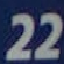

In [43]:
box = getWholeBox(train_dataset, 33400, im)

im = im.crop((box["left"], box["top"], box["right"], box["bottom"]))
im.resize((64, 64))

In [19]:
# Load Train Data
train_count = train_dataset["digitStruct"]["name"].shape[0]

X_train = np.ndarray(shape=(train_count, 64, 64, 3), dtype='float32')
y = {
    0: np.zeros(train_count),
    1: np.ones(train_count) * 10,
    2: np.ones(train_count) * 10,
    3: np.ones(train_count) * 10,
    4: np.ones(train_count) * 10,
    5: np.ones(train_count) * 10
}

for i in range(train_count):
    im = Image.open("train/" + getName(train_dataset, i))
    box = getWholeBox(train_dataset, i, im)
    if len(box["label"]) > 5:
        continue
    im = im.crop((box["left"], box["top"], box["right"], box["bottom"])).resize((64, 64))
    
    X_train[i,:,:,:] = np.array(im.resize((64, 64)), dtype='float32')
    
    labels = box["label"]
    
    y[0][i] = len(labels)
    
    for j in range(0, 5):
        if j < len(labels):
            if labels[j] == 10:
                y[j+1][i] = 10
            else:
                y[j+1][i] = int(labels[j])
        else:
            y[j+1][i] = 10
            
    if i % 500 == 0:
        print(i, len(y[0]))

0 33402
500 33402
1000 33402
1500 33402
2000 33402
2500 33402
3000 33402
3500 33402
4000 33402
4500 33402
5000 33402
5500 33402
6000 33402
6500 33402
7000 33402
7500 33402
8000 33402
8500 33402
9000 33402
9500 33402
10000 33402
10500 33402
11000 33402
11500 33402
12000 33402
12500 33402
13000 33402
13500 33402
14000 33402
14500 33402
15000 33402
15500 33402
16000 33402
16500 33402
17000 33402
17500 33402
18000 33402
18500 33402
19000 33402
19500 33402
20000 33402
20500 33402
21000 33402
21500 33402
22000 33402
22500 33402
23000 33402
23500 33402
24000 33402
24500 33402
25000 33402
25500 33402
26000 33402
26500 33402
27000 33402
27500 33402
28000 33402
28500 33402
29000 33402
29500 33402
30000 33402
30500 33402
31000 33402
31500 33402
32000 33402
32500 33402
33000 33402


In [20]:
y_train = [
    np.array(y[0]).reshape(train_count, 1),
    np.array(y[1]).reshape(train_count, 1),
    np.array(y[2]).reshape(train_count, 1),
    np.array(y[3]).reshape(train_count, 1),
    np.array(y[4]).reshape(train_count, 1),
    np.array(y[5]).reshape(train_count, 1)
]

In [26]:
# Load Test Data
test_count = test_dataset["digitStruct"]["name"].shape[0]

X_test = np.ndarray(shape=(test_count, 64, 64, 3), dtype='float32')
y = {
    0: np.zeros(test_count),
    1: np.ones(test_count) * 10,
    2: np.ones(test_count) * 10,
    3: np.ones(test_count) * 10,
    4: np.ones(test_count) * 10,
    5: np.ones(test_count) * 10
}

for i in range(test_count):
    im = Image.open("test/" + getName(test_dataset, i))
    box = getWholeBox(test_dataset, i, im)
    if len(box["label"]) > 5:
        continue
    im = im.crop((box["left"], box["top"], box["right"], box["bottom"])).resize((64, 64))
    
    X_test[i,:,:,:] = np.array(im.resize((64, 64)), dtype='float32')
    
    labels = box["label"]
    
    y[0][i] = len(labels)
    
    for j in range(0, 5):
        if j < len(labels):
            if labels[j] == 10:
                y[j+1][i] = 10
            else:
                y[j+1][i] = int(labels[j])
        else:
            y[j+1][i] = 10
            
    if i % 500 == 0:
        print(i, len(y[0]))

y_test = [
    np.array(y[0]).reshape(test_count, 1),
    np.array(y[1]).reshape(test_count, 1),
    np.array(y[2]).reshape(test_count, 1),
    np.array(y[3]).reshape(test_count, 1),
    np.array(y[4]).reshape(test_count, 1),
    np.array(y[5]).reshape(test_count, 1)
]

0 13068
500 13068
1000 13068
1500 13068
2000 13068
2500 13068
3000 13068
3500 13068
4000 13068
4500 13068
5000 13068
5500 13068
6000 13068
6500 13068
7000 13068
7500 13068
8000 13068
8500 13068
9000 13068
9500 13068
10000 13068
10500 13068
11000 13068
11500 13068
12000 13068
12500 13068
13000 13068


## Train with Keras

In [21]:
from keras.layers import Activation, Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.models import Model
from keras.layers.merge import Concatenate


def build_model():
    input_ = Input(shape=(64, 64, 3))

    # conv layer 1
    model = BatchNormalization()(input_)
    model = Conv2D(64, (7, 7), activation ='relu', padding='same')(model)
    model = MaxPool2D(pool_size=(2, 2))(model)

    # conv layer 2
    model = BatchNormalization()(model)
    model = Conv2D(128, (5, 5), activation ='relu', padding='valid')(model)
    model = MaxPool2D(pool_size=(2, 2))(model)

    # conv layer 3
    model = BatchNormalization()(model)
    model = Conv2D(256, (3, 3), activation ='relu', padding='valid')(model)
    model = MaxPool2D(pool_size=(2, 2))(model)
    model = Dropout(0.5)(model)

    # fully connected layer
    model = Flatten()(model)
    model = Dense(1024, activation='relu')(model)
    model = Dense(512, activation='relu')(model)

    x1 = Dense(6,  activation='softmax')(model)
    x2 = Dense(11, activation='softmax')(model)
    x3 = Dense(11, activation='softmax')(model)
    x4 = Dense(11, activation='softmax')(model)
    x5 = Dense(11, activation='softmax')(model)
    x6 = Dense(11, activation='softmax')(model)

    x = [x1, x2, x3, x4, x5, x6]

    model = Model(inputs=input_, outputs=x)
    return model

Using TensorFlow backend.


In [22]:
model = build_model()

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   9472        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [24]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy'])

In [25]:
model.fit(X_train, y_train, batch_size=64, epochs=20)

Epoch 1/20
33402/33402 [==============================] - 422s 13ms/step - loss: 6.5674 - dense_3_loss: 1.0041 - dense_4_loss: 2.0259 - dense_5_loss: 2.2145 - dense_6_loss: 1.0766 - dense_7_loss: 0.2326 - dense_8_loss: 0.0138 - dense_3_acc: 0.7102 - dense_4_acc: 0.4511 - dense_5_acc: 0.3842 - dense_6_acc: 0.7515 - dense_7_acc: 0.9612 - dense_8_acc: 0.9979
Epoch 2/20
33402/33402 [==============================] - 411s 12ms/step - loss: 2.2886 - dense_3_loss: 0.2033 - dense_4_loss: 0.6777 - dense_5_loss: 0.7779 - dense_6_loss: 0.4972 - dense_7_loss: 0.1286 - dense_8_loss: 0.0039 - dense_3_acc: 0.9308 - dense_4_acc: 0.7873 - dense_5_acc: 0.7477 - dense_6_acc: 0.8438 - dense_7_acc: 0.9651 - dense_8_acc: 0.9998
Epoch 3/20
33402/33402 [==============================] - 451s 14ms/step - loss: 1.7484 - dense_3_loss: 0.1618 - dense_4_loss: 0.5204 - dense_5_loss: 0.5752 - dense_6_loss: 0.3803 - dense_7_loss: 0.1067 - dense_8_loss: 0.0039 - dense_3_acc: 0.9474 - dense_4_acc: 0.8388 - dense_5_acc:

In [28]:
res = model.evaluate(X_test, y_test)

13068/13068 [==============================] - 39s 3ms/step


In [33]:
res[7:]

[0.959366391184573,
 0.8842975206794015,
 0.8696816651362106,
 0.9516375880194688,
 0.9941842669115396,
 0.9999234771962044]